**Dirichlet Variational Autoencoder (DVAE)**
---
**Imports**

---

External libraries required for operation

In [1]:
import json
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from data_manager import data_preprocessor as preproc
from data_manager import fixed_splitter as fs
from model_manager import model_generator, model_trainer, model_storage, model_evaluation
from grapher import graph_generator as gg
from tensorflow.keras import Model
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam



Opening the trainer_config.json file, which contains hyperparameters

In [2]:
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
model_type = 'EDL'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

**Data Preprocessing**

---

Splitting / preprocessing data. This will normalize the signal data and also split the background training data into training, validation and tesing groups.

In [3]:
preprocessed_data = preproc.get_data(train_config)

Ato4l = preproc.get_data(train_config, "Ato4l_lepFilter_13TeV")
hToTauTau = preproc.get_data(train_config, "hToTauTau_13TeV_PU20")
hChToTauNu = preproc.get_data(train_config, "hChToTauNu_13TeV_PU20")
leptoquark = preproc.get_data(train_config, "leptoquark_LOWMASS_lepFilter_13TeV")

Ato4l = preproc.normalize_data(Ato4l)
hToTauTau = preproc.normalize_data(hToTauTau)
hChToTauNu = preproc.normalize_data(hChToTauNu)
leptoquark = preproc.normalize_data(leptoquark)

signal_data = np.concatenate([
    Ato4l, 
    hToTauTau,
    hChToTauNu,
    leptoquark
])

data_train, data_validate, data_test = fs.generate_fixed_trainingdata_split(train_config, preprocessed_data, True)

Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (50000, 57)


**Model Initialization**

---

Initialize an instance of the above class

In [4]:
class EDLModel(Model): # TODO make this into its own function, having the priot_alpha is undefined bug, not sure why
    """
    This model replaces the VAE parameters with the Dirichlet Paramaters

    """
    def __init__(self, train_config):
        super(EDLModel, self).__init__()
        self.input_shape = (train_config["encoder_design"]["input_layer_dimension"],)
        self.latent_dim = 2 # This is fixed since we have just two classes
        self.train_config = train_config
        self.kl_losses = []

        # Encoder
        self.encoder_input = layers.Input(shape=self.input_shape)
        dimensions = train_config["encoder_design"]["inner_layer_dimensions"]
        x = self.encoder_input
        for dim in dimensions:
            self.encoder_x = layers.Dense(dim, activation='relu')(x)
            x = self.encoder_x
        self.alpha = layers.Dense(self.latent_dim, activation='softplus')(self.encoder_x)
        self.z = Sampling()(self.alpha)

        # Decoder
        self.decoder_input = layers.Input(shape=(self.latent_dim,))
        op_layer_dimension_list = train_config["decoder_design"]["inner_layer_dimensions"]
        x = self.decoder_input
        for dim in op_layer_dimension_list:
            self.decoder_x = layers.Dense(dim, activation='relu')(x)
            x = self.decoder_x
        self.decoder_output = layers.Dense(self.input_shape[0], activation='relu')(self.decoder_x)

        self.encoder = Model(self.encoder_input, [self.z, self.alpha])
        self.decoder = Model(self.decoder_input, self.decoder_output)

        self.num_classes = train_config["encoder_design"]["latent_layer_dimension"]
        self.prior_alpha = tf.constant([1.0] * self.num_classes, dtype=tf.float32)

    def call(self, inputs):
        alpha, z = self.encoder(inputs)
        prior_alpha = tf.broadcast_to(self.prior_alpha, tf.shape(alpha))
        strength = self.train_config["hyperparameters"]["kl_strength"]
        kl_loss = strength * tf.reduce_sum(tfp.distributions.Dirichlet(alpha).kl_divergence(tfp.distributions.Dirichlet(prior_alpha))) #TODO debug 
        reconstructed = self.decoder(z)
        mse = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = mse(inputs, reconstructed) * self.input_shape[0]

        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return reconstructed


class Sampling(layers.Layer):
    """Uses the alpha dirichlet to sample"""

    def call(self, inputs):
        return tfp.distributions.Dirichlet(inputs).sample()
    
model = EDLModel(train_config)

2025-07-25 15:08:10.384708: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**Model Training**

---

compiling EDL
Epoch 1/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 15621365.0000 - val_loss: 80529.7344 - learning_rate: 0.0010
Epoch 2/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1027086.6250 - val_loss: 23906.0664 - learning_rate: 0.0010
Epoch 3/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 24546.2520 - val_loss: 7427.4639 - learning_rate: 0.0010
Epoch 4/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 20912.8770 - val_loss: 4672.0049 - learning_rate: 0.0010
Epoch 5/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 5422.2153 - val_loss: 5060.3389 - learning_rate: 0.0010
Epoch 6/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 4558.4321 - val_loss: 2345.7869 - learning_rate: 0.0010
Epoch 7/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1898.0811 - val_loss: 1272.1620 - learning_rate: 0.0010
Epoch 8/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 1090.2200 - val_loss: 691.7392 - learning_rate: 0.0010
Epoch 9/20
1954/1954 ━━━

/sdf/home/b/begeldan/evidential-dl-ae/grapher/graph_generator.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


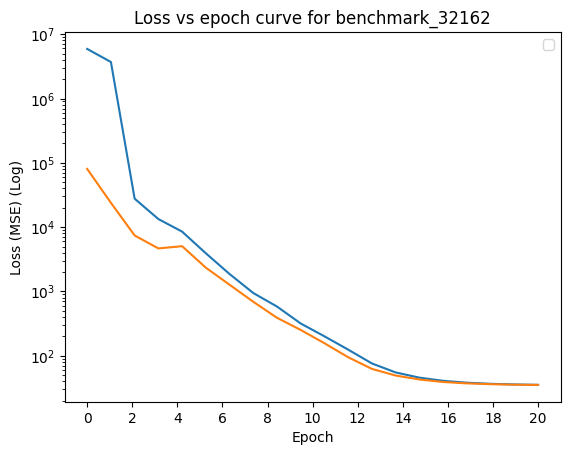

In [5]:
early_stopping = EarlyStopping(patience=train_config["hyperparameters"]["stop_patience"], restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=train_config["hyperparameters"]["lr_patience"], verbose=1)

print("compiling EDL")
model.compile(optimizer=Adam())
x_train = data_train
y_train = data_train
x_val = data_validate
y_val = data_validate
history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=train_config["hyperparameters"]["epochs"],
            batch_size=train_config["hyperparameters"]["batch_size"],
            callbacks=[early_stopping, reduce_lr]
            )


gg.generate_loss_vs_epoch(train_config, history, model_type)

**Model Evaluation**

---

calculate loss for evaluation

In [6]:


# N = 50000
# data_test = data_test[:50000]
# Ato4l = Ato4l[:50000]
# hToTauTau = hToTauTau[:50000]
# hChToTauNu = hChToTauNu[:50000]
# leptoquark = leptoquark[:50000]

# strength = model.train_config["hyperparameters"]["kl_strength"]
# num_classes = model.latent_dim
# prior_alpha_constant = tf.constant([1.0] * num_classes, dtype=tf.float32)

# alpha, z = model.encoder(data_test)
# prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
# kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
#                                 tfp.distributions.Dirichlet(prior_alpha_broadcasted))
# kl_background = (strength * kl_divergences_per_sample).numpy()

# alpha, z = model.encoder(Ato4l)
# prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
# kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
#                                 tfp.distributions.Dirichlet(prior_alpha_broadcasted))
# kl_Ato4l = (strength * kl_divergences_per_sample).numpy()

# alpha, z = model.encoder(hToTauTau)
# prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
# kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
#                                 tfp.distributions.Dirichlet(prior_alpha_broadcasted))
# kl_hToTauTau = (strength * kl_divergences_per_sample).numpy()

# alpha, z = model.encoder(hChToTauNu)
# prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
# kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
#                                 tfp.distributions.Dirichlet(prior_alpha_broadcasted))
# kl_hChToTauNu = (strength * kl_divergences_per_sample).numpy()

# alpha, z = model.encoder(leptoquark)
# prior_alpha_broadcasted = tf.broadcast_to(prior_alpha_constant, tf.shape(alpha))
# kl_divergences_per_sample = tfp.distributions.Dirichlet(alpha).kl_divergence(
#                                 tfp.distributions.Dirichlet(prior_alpha_broadcasted))
# kl_leptoquark = (strength * kl_divergences_per_sample).numpy()



# reconstructed_background = model(data_test).numpy()
# reconstructed_Ato4l = model(Ato4l).numpy()
# reconstructed_hToTauTau = model(hToTauTau).numpy()
# reconstructed_hChToTauNu = model(hChToTauNu).numpy()
# reconstructed_leptoquark = model(leptoquark).numpy()

# background_scores = ((reconstructed_background-data_test)**2)
# Ato4l_scores = ((reconstructed_Ato4l - Ato4l)**2)
# hToTauTau_scores = ((reconstructed_hToTauTau - hToTauTau)**2)
# hChToTauNu_scores = ((reconstructed_hChToTauNu - hChToTauNu)**2)
# leptoquark_scores = ((reconstructed_leptoquark - leptoquark)**2)

# background_scores = np.mean(background_scores,axis=1,keepdims=True)
# Ato4l_scores = np.mean(Ato4l_scores,axis=1,keepdims=True)
# hToTauTau_scores = np.mean(hToTauTau_scores,axis=1,keepdims=True)
# hChToTauNu_scores = np.mean(hChToTauNu_scores,axis=1,keepdims=True)
# leptoquark_scores = np.mean(leptoquark_scores,axis=1,keepdims=True)

mse_background, kl_background = model_evaluation.calculate_loss(train_config, model, data_test, model_type)
mse_Ato4l, kl_Ato4l = model_evaluation.calculate_loss(train_config, model, Ato4l, model_type)
mse_hToTauTau, kl_hToTauTau = model_evaluation.calculate_loss(train_config, model, hToTauTau, model_type)
mse_hChToTauNu, kl_hChToTauNu = model_evaluation.calculate_loss(train_config, model, hChToTauNu, model_type)
mse_leptoquark, kl_leptoquark = model_evaluation.calculate_loss(train_config, model, leptoquark, model_type)

Loss frequency plots

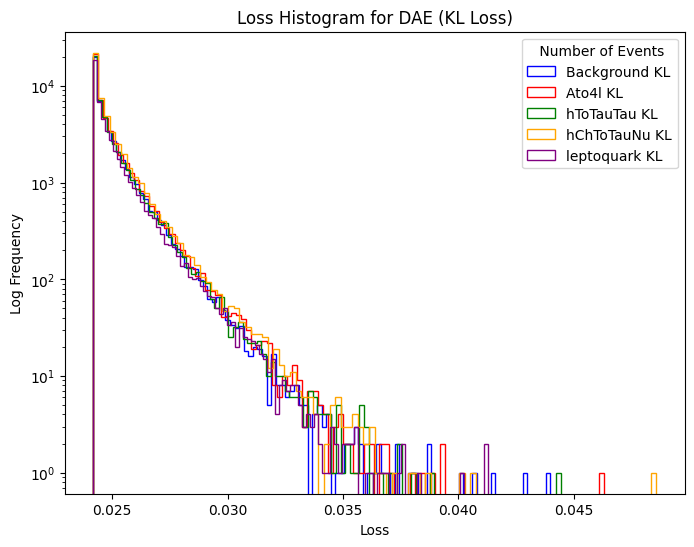

In [12]:
# gg.generate_roc_curve(train_config, truth_values, scores)
plt.figure(figsize=(8, 6))

#TODO make this into a for loop and into its own function


#MSE loss
# plt.hist(mse_background, histtype='step', bins=train_config["outputs"]["bins"], label='Background MSE', color='blue')
# plt.hist(mse_Ato4l, histtype='step', bins=train_config["outputs"]["bins"], label='Ato4l MSE', color='red')
# plt.hist(mse_hToTauTau, histtype='step', bins=train_config["outputs"]["bins"], label='hToTauTau MSE', color= 'green')
# plt.hist(mse_hChToTauNu, histtype='step', bins=train_config["outputs"]["bins"], label='hChToTauNu MSE', color='orange')
# plt.hist(mse_leptoquark,histtype='step', bins = train_config["outputs"]["bins"], label='leptoquark MSE', color='purple')

#KL Loss
plt.hist(kl_background, histtype='step', bins=train_config["outputs"]["bins"], label='Background KL', color = 'blue')
plt.hist(kl_Ato4l, histtype='step', bins=train_config["outputs"]["bins"],label='Ato4l KL', color = 'red')
plt.hist(kl_hToTauTau, histtype='step', bins=train_config["outputs"]["bins"], label = 'hToTauTau KL', color='green')
plt.hist(kl_hChToTauNu, histtype='step', bins=train_config["outputs"]["bins"], label = 'hChToTauNu KL', color='orange')
plt.hist(kl_leptoquark, histtype='step', bins=train_config["outputs"]["bins"], label = 'leptoquark KL',color='purple')


plt.xlabel('Loss')
plt.ylabel('Log Frequency')
plt.yscale('log')
plt.title("Loss Histogram for DAE (KL Loss)")
plt.legend(title=" Number of Events")
plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
        train_config["outputs"]["date_time_format"]) + "KL_Histogram.png"), format="png", bbox_inches="tight")
plt.show()


In [8]:
# gg.generate_histogram(train_config, background_scores, signal_scores, train_config["data_files"]["signal_labels"] )